In [278]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import seaborn as sns
sns.set()
import sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras import utils
from tensorflow.python.keras import backend
import os
import tempfile

In [3]:
# Load the plant 1 training data set
train1 = pd.read_csv('plant1_train.csv')
train1 = train1.fillna(0)
train1 = train1.iloc[:,2:]
train1['mea_ddhr'] = pd.to_datetime(train1['mea_ddhr'])
train1['plant'] = 1
train1 = pd.wide_to_long(train1, ["tem_in", "hum_in","tem_coil","cond"], i=["mea_ddhr"], j="loc", sep='_loc')
train1.tail()

,,tem_out_loc1,plant,hum_out_loc1,tem_in,hum_in,tem_coi,cond
mea_ddhr,loc,,,,,,,
2019-03-31 23:10:00,3,6.40,1,43.86,9.85,37.88,9.79,0.0
2019-03-31 23:20:00,3,6.34,1,44.02,9.88,38.40,9.72,0.0
2019-03-31 23:30:00,3,6.40,1,43.04,9.85,38.22,9.91,0.0
2019-03-31 23:40:00,3,6.31,1,45.33,9.82,38.95,9.83,0.0
2019-03-31 23:50:00,3,6.34,1,45.94,9.82,39.35,9.83,0.0


In [4]:
# Load the plant 2 training data set
train2 = pd.read_csv('plant2_train.csv')
train2 = train2.fillna(0)
train2 = train2.iloc[:,2:]
train2['mea_ddhr'] = pd.to_datetime(train2['mea_ddhr'])
train2['plant'] = 2
train2 = pd.wide_to_long(train2, ["tem_in", "hum_in","tem_coil","cond"], i=["mea_ddhr"], j="loc", sep='_loc')
train2.tail()

,,tem_out_loc1,plant,hum_out_loc1,tem_in,hum_in,tem_coi,cond
mea_ddhr,loc,,,,,,,
2019-03-31 23:10:00,3,4.72,2,52.11,8.26,38.34,9.57,0.0
2019-03-31 23:20:00,3,4.66,2,51.01,8.29,38.92,9.60,0.0
2019-03-31 23:30:00,3,4.57,2,51.47,8.32,39.13,9.49,0.0
2019-03-31 23:40:00,3,4.47,2,53.14,8.26,39.62,9.57,0.0
2019-03-31 23:50:00,3,0.00,2,0.00,0.00,0.00,0.00,0.0


In [5]:
frames = [train1, train2]
total_train = pd.concat(frames)
total_train = total_train.reset_index()
total_train = total_train.iloc[:,[0,4,1,5,6,7,2,3,8]]
total_train.head()

,mea_ddhr,hum_out_loc1,loc,tem_in,hum_in,tem_coi,tem_out_loc1,plant,cond
0,2016-04-01 00:00:00,42.0,1,16.0,24.0,11.0,9.0,1,0.0
1,2016-04-01 03:00:00,59.0,1,14.0,28.0,10.0,7.0,1,0.0
2,2016-04-01 06:00:00,56.0,1,13.0,33.0,10.0,6.0,1,0.0
3,2016-04-01 09:00:00,30.0,1,13.0,33.0,10.0,18.0,1,0.0
4,2016-04-01 12:00:00,20.0,1,16.0,28.0,10.0,18.0,1,0.0


In [6]:
total_train.shape

(349989, 9)

In [7]:
total_train['x24h_tma'] = total_train['mea_ddhr'] + timedelta(days=1)
total_train['x24h_cond_loc'] = 0
total_train['x48h_tma'] = total_train['mea_ddhr'] + timedelta(days=2)
total_train['x48h_cond_loc'] = 0

In [8]:
total_train = total_train.reset_index(drop=True)

In [9]:
condensation = total_train[total_train['cond'] == 1].sort_values(by=['mea_ddhr'])

In [10]:
condensation.head()

,mea_ddhr,hum_out_loc1,loc,tem_in,hum_in,tem_coi,tem_out_loc1,plant,cond,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc
117541,2016-04-06 09:00:00,45.0,3,13.0,84.0,11.0,11.0,1,1.0,2016-04-07 09:00:00,0,2016-04-08 09:00:00,0
117557,2016-04-08 09:00:00,75.0,3,12.0,82.0,9.0,9.0,1,1.0,2016-04-09 09:00:00,0,2016-04-10 09:00:00,0
58808,2016-04-08 09:00:00,75.0,2,13.0,80.0,10.0,9.0,1,1.0,2016-04-09 09:00:00,0,2016-04-10 09:00:00,0
117558,2016-04-08 12:00:00,63.0,3,13.0,80.0,10.0,12.0,1,1.0,2016-04-09 12:00:00,0,2016-04-10 12:00:00,0
117563,2016-04-09 03:00:00,80.0,3,13.0,77.0,10.0,9.0,1,1.0,2016-04-10 03:00:00,0,2016-04-11 03:00:00,0


In [11]:
condensation = condensation.reset_index(drop=True)

In [12]:
total_train[(total_train['x24h_tma'] == condensation['mea_ddhr'].values[0]) & (total_train['plant'] == condensation['plant'].values[0]) & (total_train['loc'] == condensation['loc'].values[0])]['x24h_cond_loc']

117533    0
Name: x24h_cond_loc, dtype: int64

In [13]:
for i in range(len(condensation['mea_ddhr'].values)):
    total_train.loc[(total_train['x24h_tma'] == condensation['mea_ddhr'].values[i]) & (total_train['plant'] == condensation['plant'].values[i]) & (total_train['loc'] == condensation['loc'].values[i]), 'x24h_cond_loc'] = 1
    total_train.loc[(total_train['x48h_tma'] == condensation['mea_ddhr'].values[i]) & (total_train['plant'] == condensation['plant'].values[i]) & (total_train['loc'] == condensation['loc'].values[i]), 'x48h_cond_loc'] = 1
    

In [14]:
total_train.describe()

,hum_out_loc1,loc,tem_in,hum_in,tem_coi,tem_out_loc1,plant,cond,x24h_cond_loc,x48h_cond_loc
count,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000
mean,61.745743,2.000000,16.300226,52.241778,15.860972,13.583537,1.496421,0.005654,0.005654,0.005654
std,19.050421,0.816498,10.021232,14.334147,10.148261,11.089872,0.499988,0.074983,0.074983,0.074983
min,0.000000,1.000000,-8.930000,0.000000,-7.610000,-14.270000,1.000000,0.000000,0.000000,0.000000
25%,47.190000,1.000000,7.340000,41.700000,6.590000,3.960000,1.000000,0.000000,0.000000,0.000000
50%,61.050000,2.000000,15.530000,52.410000,15.100000,12.870000,1.000000,0.000000,0.000000,0.000000
75%,76.950000,3.000000,25.450000,63.100000,25.320000,23.130000,2.000000,0.000000,0.000000,0.000000
max,99.510000,3.000000,37.080000,93.160000,35.240000,43.420000,2.000000,1.000000,1.000000,1.000000


In [15]:
total_train = total_train.drop('cond', axis = 1)

In [45]:
total_train = total_train.iloc[:,[0,7,2,3,4,5,6,1,8,9,10,11]]
total_train.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coi,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc
0,2016-04-01 00:00:00,1,1,16.0,24.0,11.0,9.0,42.0,2016-04-02 00:00:00,0,2016-04-03 00:00:00,0
1,2016-04-01 03:00:00,1,1,14.0,28.0,10.0,7.0,59.0,2016-04-02 03:00:00,0,2016-04-03 03:00:00,0
2,2016-04-01 06:00:00,1,1,13.0,33.0,10.0,6.0,56.0,2016-04-02 06:00:00,0,2016-04-03 06:00:00,0
3,2016-04-01 09:00:00,1,1,13.0,33.0,10.0,18.0,30.0,2016-04-02 09:00:00,0,2016-04-03 09:00:00,0
4,2016-04-01 12:00:00,1,1,16.0,28.0,10.0,18.0,20.0,2016-04-02 12:00:00,0,2016-04-03 12:00:00,0


In [46]:
# Load the plant test data set
test = pd.read_csv('plant_test.csv')
test = test.iloc[:,1:]
test['mea_ddhr'] = pd.to_datetime(test['mea_ddhr'])
test.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc
0,2019-04-01 00:00:00,2,3,8.17,40.42,10.10,4.20,54.82,2019-04-02 0:00,NaN,2019-04-03 0:00,NaN
1,2019-04-01 04:30:00,1,2,10.03,48.81,10.79,6.09,59.34,2019-04-02 4:30,NaN,2019-04-03 4:30,NaN
2,2019-04-01 10:30:00,2,3,9.45,40.93,9.07,12.26,32.14,2019-04-02 10:30,NaN,2019-04-03 10:30,NaN
3,2019-04-01 11:00:00,1,1,12.32,34.13,10.86,12.32,28.27,2019-04-02 11:00,NaN,2019-04-03 11:00,NaN
4,2019-04-01 13:30:00,2,1,11.28,22.65,8.76,12.01,19.84,2019-04-02 13:30,NaN,2019-04-03 13:30,NaN


In [47]:
# Load the weather data from the observation point on the outside of factory
weather = pd.read_csv('weather_data.csv')
weather = weather.iloc[:,1:]
weather['일시'] = pd.to_datetime(weather['일시'])
weather.tail()

,일시,기온(°C),누적강수량(mm),풍속(m/s),현지기압(hPa),해면기압(hPa),습도(%)
111282,2020-03-31 23:20:00,7.5,0.0,1.4,1012.7,1015.8,59.0
111283,2020-03-31 23:30:00,8.0,0.0,1.0,1012.7,1015.8,52.5
111284,2020-03-31 23:40:00,8.6,0.0,1.6,1012.7,1015.8,46.0
111285,2020-03-31 23:50:00,8.6,0.0,1.0,1012.7,1015.8,47.2
111286,2020-04-01 00:00:00,8.4,0.0,0.8,1012.7,1015.8,52.0


In [48]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 176247 entries, (2016-04-01 00:00:00, 1) to (2019-03-31 23:50:00, 3)
Data columns (total 7 columns):
tem_out_loc1    176247 non-null float64
plant           176247 non-null int64
hum_out_loc1    176247 non-null float64
tem_in          176247 non-null float64
hum_in          176247 non-null float64
tem_coi         176247 non-null float64
cond            176247 non-null float64
dtypes: float64(6), int64(1)
memory usage: 18.2 MB


In [49]:
weather.describe()

,기온(°C),누적강수량(mm),풍속(m/s),현지기압(hPa),해면기압(hPa),습도(%)
count,111279.000000,109149.000000,111283.000000,111273.000000,111273.000000,111284.000000
mean,12.476933,1.373145,1.859155,1014.106383,1017.311511,73.044964
std,10.515506,7.172807,1.555926,8.499238,8.584265,20.585989
min,-15.600000,0.000000,0.000000,983.500000,986.300000,8.900000
25%,3.600000,0.000000,0.700000,1007.400000,1010.500000,57.200000
50%,12.400000,0.000000,1.500000,1014.500000,1017.700000,75.600000
75%,21.600000,0.000000,2.800000,1020.600000,1023.900000,92.700000
max,37.100000,139.300000,13.200000,1036.400000,1039.800000,100.000000


In [50]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111287 entries, 0 to 111286
Data columns (total 7 columns):
일시           111287 non-null datetime64[ns]
기온(°C)       111279 non-null float64
누적강수량(mm)    109149 non-null float64
풍속(m/s)      111283 non-null float64
현지기압(hPa)    111273 non-null float64
해면기압(hPa)    111273 non-null float64
습도(%)        111284 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 5.9 MB


In [51]:
weather.shape

(111287, 7)

In [52]:
train1.shape

(176247, 7)

In [53]:
weather = weather.rename(columns={'일시': 'mea_ddhr','기온(°C)':'out_temp','누적강수량(mm)':'cum_rain','풍속(m/s)':'wind_speed','현지기압(hPa)':'land_pressure','해면기압(hPa)':'ocean_pressure','습도(%)':'out_humidity'})

In [54]:
mix_train = total_train.merge(weather, on='mea_ddhr', how='left')

In [55]:
mix_test = test.merge(weather, on='mea_ddhr', how='left')

In [439]:
final_submit = pd.read_csv("참가번호6자리.csv")

In [440]:
final_submit.head()

,MEA_DDHR,PLANT,LOC,X24H_TMA,X24H_COND_LOC,X24H_COND_LOC_PROB,X48H_TMA,X48H_COND_LOC,X48H_COND_LOC_PROB
0,2019-04-01 0:00,2,3,2019-04-02 0:00,NaN,NaN,2019-04-03 0:00,NaN,NaN
1,2019-04-01 4:30,1,2,2019-04-02 4:30,NaN,NaN,2019-04-03 4:30,NaN,NaN
2,2019-04-01 10:30,2,3,2019-04-02 10:30,NaN,NaN,2019-04-03 10:30,NaN,NaN
3,2019-04-01 11:00,1,1,2019-04-02 11:00,NaN,NaN,2019-04-03 11:00,NaN,NaN
4,2019-04-01 13:30,2,1,2019-04-02 13:30,NaN,NaN,2019-04-03 13:30,NaN,NaN


## EDA

In [56]:
mix_train = mix_train.rename(columns={'tem_coi': 'tem_coil'})
mix_train.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc,out_temp,cum_rain,wind_speed,land_pressure,ocean_pressure,out_humidity
0,2016-04-01 00:00:00,1,1,16.0,24.0,11.0,9.0,42.0,2016-04-02 00:00:00,0,2016-04-03 00:00:00,0,8.8,0.0,1.5,1012.1,1015.6,41.0
1,2016-04-01 03:00:00,1,1,14.0,28.0,10.0,7.0,59.0,2016-04-02 03:00:00,0,2016-04-03 03:00:00,0,7.5,0.0,0.4,1011.4,1014.9,40.0
2,2016-04-01 06:00:00,1,1,13.0,33.0,10.0,6.0,56.0,2016-04-02 06:00:00,0,2016-04-03 06:00:00,0,3.7,0.0,0.4,1011.9,1015.5,66.0
3,2016-04-01 09:00:00,1,1,13.0,33.0,10.0,18.0,30.0,2016-04-02 09:00:00,0,2016-04-03 09:00:00,0,12.9,0.0,0.7,1013.2,1016.7,41.0
4,2016-04-01 12:00:00,1,1,16.0,28.0,10.0,18.0,20.0,2016-04-02 12:00:00,0,2016-04-03 12:00:00,0,20.5,0.0,2.4,1012.4,1015.8,24.0


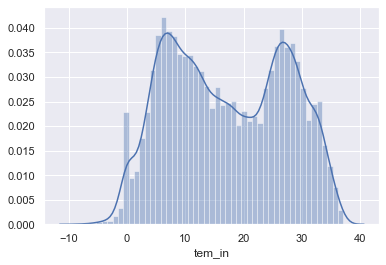

In [57]:
sns.distplot(mix_train[(mix_train["plant"] == 1) & (mix_train["loc"] == 1)]['tem_in'].dropna())

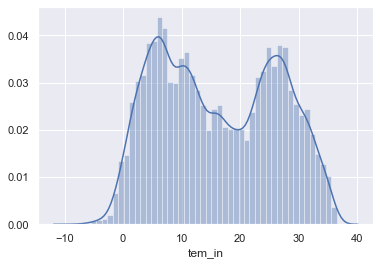

In [58]:
sns.distplot(mix_train[(mix_train["plant"] == 1) & (mix_train["loc"] == 2)]['tem_in'].dropna())

In [59]:
train1_2018 = mix_train[(mix_train['mea_ddhr'] < '2019-01-01 00:00:00') &(mix_train['mea_ddhr'] >= '2018-01-01 00:00:00')]
train1_2018.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc,out_temp,cum_rain,wind_speed,land_pressure,ocean_pressure,out_humidity
10850,2018-01-01 00:00:00,1,1,6.83,35.87,6.05,0.93,45.79,2018-01-02 00:00:00,0,2018-01-03 00:00:00,0,-2.1,0.0,1.1,1023.6,1027.3,70.0
10851,2018-01-01 01:00:00,1,1,6.79,33.79,6.05,0.29,49.66,2018-01-02 01:00:00,0,2018-01-03 01:00:00,0,-3.5,0.0,1.0,1023.5,1027.2,79.0
10852,2018-01-01 02:00:00,1,1,6.67,33.46,6.02,0.11,44.57,2018-01-02 02:00:00,0,2018-01-03 02:00:00,0,-4.3,0.0,0.4,1023.5,1027.3,86.0
10853,2018-01-01 03:00:00,1,1,6.46,31.35,5.94,0.05,41.97,2018-01-02 03:00:00,0,2018-01-03 03:00:00,0,-5.1,0.0,0.2,1023.8,1027.6,89.0
10854,2018-01-01 04:00:00,1,1,6.00,33.36,5.86,-2.82,58.97,2018-01-02 04:00:00,0,2018-01-03 04:00:00,0,-5.6,0.0,0.6,1023.8,1027.6,90.0


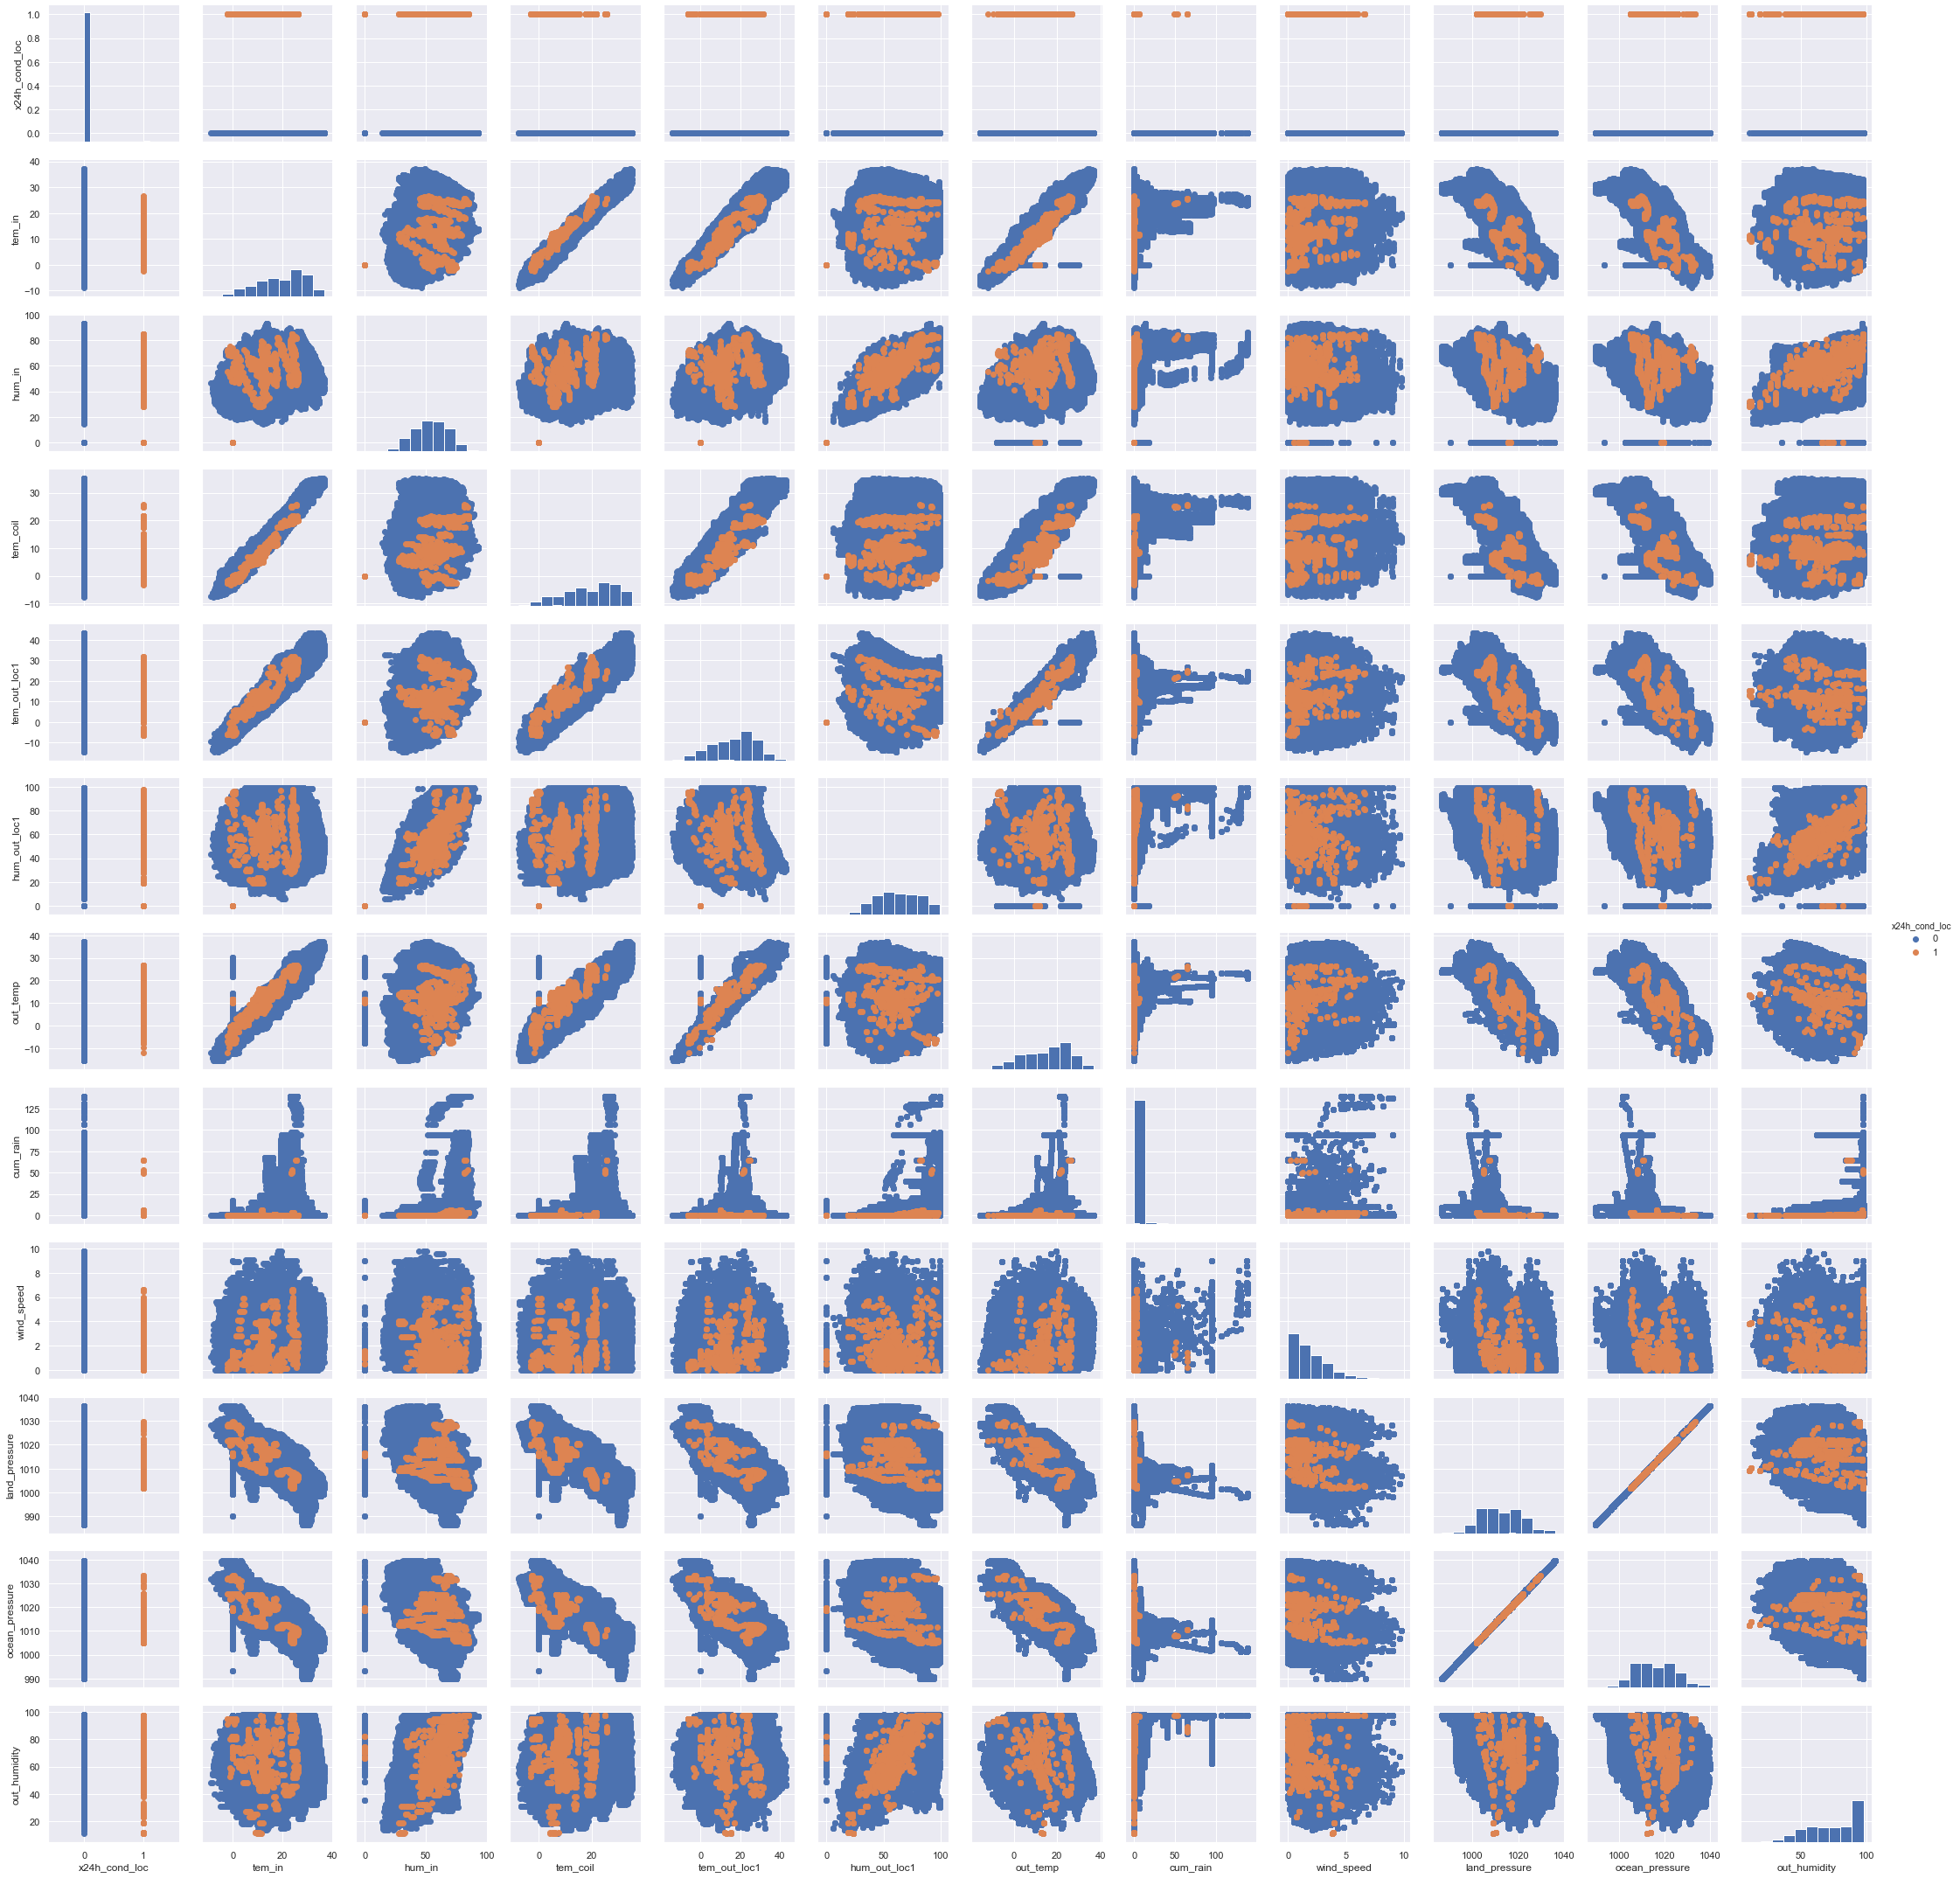

In [60]:
g = sns.PairGrid(train1_2018.iloc[:,[9,3,4,5,6,7,12,13,14,15,16,17]], hue="x24h_cond_loc")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

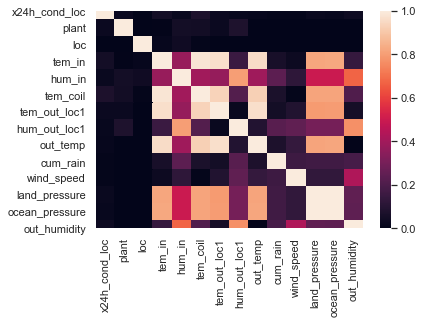

In [61]:
# Absolute correlation of each variable on 24hour later
sns.heatmap(train1_2018.iloc[:,[9,1,2,3,4,5,6,7,12,13,14,15,16,17]].corr().abs())

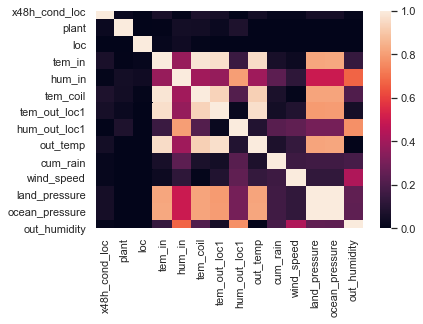

In [62]:
# Absolute correlation of each variable on 48hour later
sns.heatmap(train1_2018.iloc[:,[11,1,2,3,4,5,6,7,12,13,14,15,16,17]].corr().abs())

- For condition, only humidity related variables has meaningful correlation.
- All humidity variables are related to each other.
- Air pressure has more correlation on temperature than humidity.
- Wind speed and cumulative rain has small correlation with other variables.

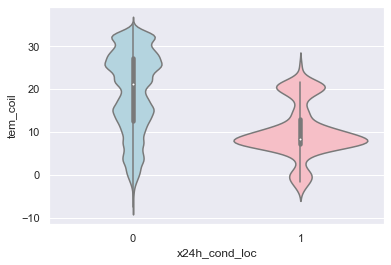

In [63]:
sns.violinplot("x24h_cond_loc", "tem_coil", data=train1_2018,
               palette=["lightblue", "lightpink"])

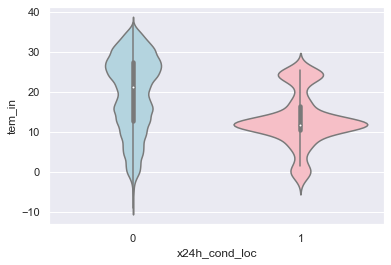

In [64]:
sns.violinplot("x24h_cond_loc", "tem_in", data=train1_2018,
               palette=["lightblue", "lightpink"])

## Feature Selection by Logistic Regression

In [65]:
mix_train = mix_train.fillna(0)

In [66]:
import statsmodels.api as sm

In [67]:
# Model for condition by each plant and location
# statsmodels requires us to add a constant column representing the intercept
mix_train['intercept']=1.0
# identify the independent variables 
ind_cols=['plant','loc','tem_in', 'hum_in','tem_coil',
          'tem_out_loc1', 'hum_out_loc1', 'out_temp', 'cum_rain', 
          'land_pressure', 'ocean_pressure', 'out_humidity']
logit = sm.Logit(mix_train['x24h_cond_loc'], mix_train[ind_cols])
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.027432
         Iterations 11


In [68]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:          x24h_cond_loc   No. Observations:               350115
Model:                          Logit   Df Residuals:                   350103
Method:                           MLE   Df Model:                           11
Date:                Thu, 25 Jun 2020   Pseudo R-squ.:                  0.2138
Time:                        23:15:07   Log-Likelihood:                -9604.4
converged:                       True   LL-Null:                       -12216.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
plant             -1.4151      0.049    -28.793      0.000      -1.511      -1.319
loc               -0.4047      0.027    -14.800      0.000      -0.458      -0.351
tem_in             0.1587      0.021

In [69]:
# Model for condition by each plant and location
# statsmodels requires us to add a constant column representing the intercept
mix_train['intercept']=1.0
# identify the independent variables 
ind_cols=['plant','loc','tem_in', 'hum_in','tem_coil',
          'tem_out_loc1', 'hum_out_loc1', 'out_temp', 'cum_rain', 
          'land_pressure', 'ocean_pressure', 'out_humidity']
logit = sm.Logit(mix_train['x48h_cond_loc'], mix_train[ind_cols])
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.031596
         Iterations 15


In [70]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:          x48h_cond_loc   No. Observations:               350115
Model:                          Logit   Df Residuals:                   350103
Method:                           MLE   Df Model:                           11
Date:                Thu, 25 Jun 2020   Pseudo R-squ.:                 0.09444
Time:                        23:15:09   Log-Likelihood:                -11062.
converged:                       True   LL-Null:                       -12216.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
plant             -1.1793      0.048    -24.500      0.000      -1.274      -1.085
loc               -0.2340      0.027     -8.628      0.000      -0.287      -0.181
tem_in         -5.266e-05      0.020

- Outside humidity doesn't seem to be significantly contributing to the regression.
- Pseudo R squared of 24hour is 21% but for the 48hour it's only 9.5% which mean that this regression has low predicting power.

## Random Forest Model

In [378]:
mix_test.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc,out_temp,cum_rain,wind_speed,land_pressure,ocean_pressure,out_humidity
0,2019-04-01 00:00:00,2,3,8.17,40.42,10.10,4.20,54.82,2019-04-02 0:00,-1,2019-04-03 0:00,-1,2.0,0.0,1.7,1020.9,1024.2,63.0
1,2019-04-01 04:30:00,1,2,10.03,48.81,10.79,6.09,59.34,2019-04-02 4:30,-1,2019-04-03 4:30,-1,-1.2,0.0,0.3,1020.4,1023.7,84.7
2,2019-04-01 10:30:00,2,3,9.45,40.93,9.07,12.26,32.14,2019-04-02 10:30,-1,2019-04-03 10:30,-1,8.4,0.0,3.4,1021.8,1025.0,32.1
3,2019-04-01 11:00:00,1,1,12.32,34.13,10.86,12.32,28.27,2019-04-02 11:00,-1,2019-04-03 11:00,-1,9.2,0.0,3.2,1021.6,1024.8,25.6
4,2019-04-01 13:30:00,2,1,11.28,22.65,8.76,12.01,19.84,2019-04-02 13:30,-1,2019-04-03 13:30,-1,9.8,0.0,3.2,1020.8,1024.0,24.9


In [72]:
# Set the label values to -1
mix_test['x24h_cond_loc'] = -1
mix_test['x48h_cond_loc'] = -1

In [73]:
# Concatenate the train and test data
frames = [mix_train, mix_test]
total_data = pd.concat(frames, sort = False)

In [386]:
# Before using Keras, set all the nan values into 0
total_data = total_data.fillna(0) 
mix_train = mix_train.fillna(0) 
mix_test = mix_test.fillna(0) 

In [387]:
loc_dummies = pd.get_dummies(total_data['loc'])
after_onehot = pd.concat([total_data, loc_dummies], axis = 1)

In [388]:
after_onehot = after_onehot.drop('loc', axis = 1)
after_onehot['plant'] = after_onehot['plant'] - 1

In [393]:
train_data = after_onehot[after_onehot['mea_ddhr'] < '2019-04-01']
test_data = after_onehot[after_onehot['mea_ddhr'] >= '2019-04-01']

In [394]:
# Labels are the values we want to predict
labels24 = np.array(train_data['x24h_cond_loc'])
labels48 = np.array(train_data['x48h_cond_loc'])
features= train_data.drop(['mea_ddhr','x24h_tma','x24h_cond_loc','x48h_tma','x48h_cond_loc'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [395]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(features, labels24);

In [397]:
# Remove the labels from the features
test_features= test_data.drop(['mea_ddhr','x24h_tma','x24h_cond_loc','x48h_tma','x48h_cond_loc'], axis = 1)

In [398]:
# Use the forest's predict method on the test data
prediction24 = rf.predict(test_features)

In [399]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: hum_in               Importance: 0.13
Variable: tem_coil             Importance: 0.12
Variable: out_temp             Importance: 0.11
Variable: land_pressure        Importance: 0.11
Variable: ocean_pressure       Importance: 0.1
Variable: hum_out_loc1         Importance: 0.09
Variable: tem_in               Importance: 0.08
Variable: wind_speed           Importance: 0.08
Variable: out_humidity         Importance: 0.08
Variable: tem_out_loc1         Importance: 0.07
Variable: plant                Importance: 0.01
Variable: cum_rain             Importance: 0.01
Variable:                    1 Importance: 0.01
Variable:                    2 Importance: 0.01
Variable:                    3 Importance: 0.01
Variable: intercept            Importance: 0.0


In [419]:
# Reduced features from the previous random forest model
reduced_features= train_data.loc[:,['hum_in','tem_coil','out_temp','land_pressure','ocean_pressure','hum_out_loc1','tem_in','wind_speed','out_humidity','tem_out_loc1']]
test_features= test_data.loc[:,['hum_in','tem_coil','out_temp','land_pressure','ocean_pressure','hum_out_loc1','tem_in','wind_speed','out_humidity','tem_out_loc1']]
# Saving feature names for later use
feature_list = list(reduced_features.columns)
# Convert to numpy array
reduced_features = np.array(reduced_features)

In [420]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(reduced_features, labels24);

In [421]:
# Use the forest's predict method on the test data
prediction24 = rf.predict(test_features)

In [422]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: hum_in               Importance: 0.14
Variable: tem_coil             Importance: 0.13
Variable: out_temp             Importance: 0.11
Variable: land_pressure        Importance: 0.11
Variable: ocean_pressure       Importance: 0.1
Variable: hum_out_loc1         Importance: 0.09
Variable: tem_in               Importance: 0.08
Variable: wind_speed           Importance: 0.08
Variable: out_humidity         Importance: 0.08
Variable: tem_out_loc1         Importance: 0.08


In [426]:
features= train_data.drop(['mea_ddhr','x24h_tma','x24h_cond_loc','x48h_tma','x48h_cond_loc'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [427]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(features, labels48);

In [428]:
# Remove the labels from the features
test_features= test_data.drop(['mea_ddhr','x24h_tma','x24h_cond_loc','x48h_tma','x48h_cond_loc'], axis = 1)

In [429]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: tem_coil             Importance: 0.16
Variable: hum_in               Importance: 0.11
Variable: land_pressure        Importance: 0.11
Variable: out_humidity         Importance: 0.11
Variable: tem_in               Importance: 0.1
Variable: out_temp             Importance: 0.08
Variable: ocean_pressure       Importance: 0.08
Variable: tem_out_loc1         Importance: 0.07
Variable: hum_out_loc1         Importance: 0.07
Variable: wind_speed           Importance: 0.05
Variable: plant                Importance: 0.01
Variable: cum_rain             Importance: 0.01
Variable:                    1 Importance: 0.01
Variable:                    2 Importance: 0.01
Variable:                    3 Importance: 0.01
Variable: intercept            Importance: 0.0


In [430]:
# Reduced features from the previous random forest model
reduced_features= train_data.loc[:,['hum_in','tem_coil','out_temp','land_pressure','ocean_pressure','hum_out_loc1','tem_in','wind_speed','out_humidity','tem_out_loc1']]
test_features= test_data.loc[:,['hum_in','tem_coil','out_temp','land_pressure','ocean_pressure','hum_out_loc1','tem_in','wind_speed','out_humidity','tem_out_loc1']]
# Saving feature names for later use
feature_list = list(reduced_features.columns)
# Convert to numpy array
reduced_features = np.array(reduced_features)

In [431]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(reduced_features, labels48);

In [432]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: tem_coil             Importance: 0.16
Variable: hum_in               Importance: 0.13
Variable: land_pressure        Importance: 0.12
Variable: out_humidity         Importance: 0.12
Variable: tem_in               Importance: 0.1
Variable: ocean_pressure       Importance: 0.09
Variable: out_temp             Importance: 0.08
Variable: hum_out_loc1         Importance: 0.08
Variable: tem_out_loc1         Importance: 0.08
Variable: wind_speed           Importance: 0.05


In [437]:
# Use the forest's predict method on the test data
prediction48 = rf.predict(test_features)
train_pred48 = rf.predict(reduced_features)

In [438]:
confusion_matrix(train_data['x48h_cond_loc'], np.round(train_pred48))

array([[348136,      0],
       [     1,   1978]])

In [441]:
final_submit.columns

Index(['MEA_DDHR', 'PLANT', 'LOC', 'X24H_TMA', 'X24H_COND_LOC',
       'X24H_COND_LOC_PROB', 'X48H_TMA', 'X48H_COND_LOC',
       'X48H_COND_LOC_PROB'],
      dtype='object')

In [452]:
final_submit['X24H_COND_LOC'] = np.round(prediction24)
final_submit['X24H_COND_LOC_PROB'] = prediction24 * 100
final_submit['X48H_COND_LOC'] = np.round(prediction48)
final_submit['X48H_COND_LOC_PROB'] = prediction48 * 100
final_submit.loc[:,['X24H_COND_LOC','X24H_COND_LOC_PROB','X48H_COND_LOC','X48H_COND_LOC_PROB']] = final_submit.loc[:,['X24H_COND_LOC','X24H_COND_LOC_PROB','X48H_COND_LOC','X48H_COND_LOC_PROB']].astype(int)

In [455]:
final_submit.describe()

,PLANT,LOC,X24H_COND_LOC,X24H_COND_LOC_PROB,X48H_COND_LOC,X48H_COND_LOC_PROB
count,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000
mean,1.479797,2.013563,0.005086,1.117830,0.001413,1.121503
std,0.499662,0.793086,0.071146,5.973842,0.037566,5.296355
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,3.000000,1.000000,90.000000,1.000000,78.000000


In [454]:
final_submit.to_csv("203672.csv")

## Keras Modeling for 24 hour Forward Prediction

In [71]:
mix_train.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc,out_temp,cum_rain,wind_speed,land_pressure,ocean_pressure,out_humidity,intercept
0,2016-04-01 00:00:00,1,1,16.0,24.0,11.0,9.0,42.0,2016-04-02 00:00:00,0,2016-04-03 00:00:00,0,8.8,0.0,1.5,1012.1,1015.6,41.0,1.0
1,2016-04-01 03:00:00,1,1,14.0,28.0,10.0,7.0,59.0,2016-04-02 03:00:00,0,2016-04-03 03:00:00,0,7.5,0.0,0.4,1011.4,1014.9,40.0,1.0
2,2016-04-01 06:00:00,1,1,13.0,33.0,10.0,6.0,56.0,2016-04-02 06:00:00,0,2016-04-03 06:00:00,0,3.7,0.0,0.4,1011.9,1015.5,66.0,1.0
3,2016-04-01 09:00:00,1,1,13.0,33.0,10.0,18.0,30.0,2016-04-02 09:00:00,0,2016-04-03 09:00:00,0,12.9,0.0,0.7,1013.2,1016.7,41.0,1.0
4,2016-04-01 12:00:00,1,1,16.0,28.0,10.0,18.0,20.0,2016-04-02 12:00:00,0,2016-04-03 12:00:00,0,20.5,0.0,2.4,1012.4,1015.8,24.0,1.0


In [75]:
def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(300, input_dim=dim, activation="relu"))
    model.add(Dense(300, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

    # return our model
    return model

In [76]:
def process_weather_attributes(df, train, test):
    # initialize the column names of the continuous data
    continuous = ["tem_in", "hum_in", "tem_coil","tem_out_loc1", "hum_out_loc1","out_temp",
                  "cum_rain","wind_speed","land_pressure","ocean_pressure","out_humidity"]

    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])

    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoing, all output features are now in the range [0, 1])
    zipBinarizer1 = LabelBinarizer().fit(df["plant"])
    zipBinarizer2 = LabelBinarizer().fit(df["loc"])
    trainCategorical1 = zipBinarizer1.transform(train["plant"])
    trainCategorical2 = zipBinarizer2.transform(train["loc"])
    testCategorical1 = zipBinarizer1.transform(test["plant"])
    testCategorical2 = zipBinarizer2.transform(test["loc"])

    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical1, trainCategorical2, trainContinuous])
    testX = np.hstack([testCategorical1, testCategorical2, testContinuous])

    # return the concatenated training and testing data
    return (trainX, testX)

In [77]:
# Define the train and test labels
trainY1 = mix_train["x24h_cond_loc"]
trainY2 = mix_train["x48h_cond_loc"]
testY1 = mix_test["x24h_cond_loc"]
testY2 = mix_test["x48h_cond_loc"]

In [78]:
# Convert the data into scaled, transformed array
(trainAttrX, testAttrX) = process_weather_attributes(total_data, mix_train, mix_test)

In [79]:
mlp = create_mlp(trainAttrX.shape[1], regress=True)

In [80]:
x = Dense(500, activation="relu")(mlp.output)
    
x = Dense(300, activation="relu")(x)
    
x = Dense(50, activation="relu")(x)
    
y = Dense(2, activation="softmax")(x)

In [81]:
model = Model(inputs=[mlp.input], outputs=y)

In [82]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [83]:
# Train model for 24 hour forward
model.fit(trainAttrX, np.array(trainY1), 
          validation_split=0.2,
          epochs=10, batch_size=1000)

Train on 280092 samples, validate on 70023 samples
Epoch 1/10
280092/280092 [==============================] - 6s 20us/sample - loss: 0.0502 - accuracy: 0.9932 - val_loss: 0.0066 - val_accuracy: 0.9991
Epoch 2/10
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0322 - accuracy: 0.9932 - val_loss: 0.0073 - val_accuracy: 0.9991
Epoch 3/10
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0303 - accuracy: 0.9932 - val_loss: 0.0065 - val_accuracy: 0.9991
Epoch 4/10
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0290 - accuracy: 0.9932 - val_loss: 0.0096 - val_accuracy: 0.9991
Epoch 5/10
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0287 - accuracy: 0.9933 - val_loss: 0.0085 - val_accuracy: 0.9984
Epoch 6/10
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0277 - accuracy: 0.9934 - val_loss: 0.0098 - val_accuracy: 0.9989
Epoch 7/10
280092/280092 [=================

In [84]:
preds = model.predict(trainAttrX)

In [85]:
preds

array([[9.9996912e-01, 3.0917505e-05],
       [9.9998152e-01, 1.8482577e-05],
       [9.9987280e-01, 1.2715840e-04],
       ...,
       [9.9999774e-01, 2.2732038e-06],
       [9.9999809e-01, 1.9648178e-06],
       [9.9999881e-01, 1.1549001e-06]], dtype=float32)

In [86]:
np.unique(preds.argmax(1))

array([0, 1])

In [87]:
scores = model.evaluate(trainAttrX, np.array(trainY1), verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   


Accuracy on training data: 0.9946731925010681% 
 Error on training data: 0.005326807498931885


## Keras Modeling for 48 hour Forward Prediction

In [88]:
# Train model for 48 hour forward
model.fit(trainAttrX, np.array(trainY2), 
          validation_split=0.2,
          epochs=100, batch_size=1000)

Train on 280092 samples, validate on 70023 samples
Epoch 1/100
280092/280092 [==============================] - 5s 16us/sample - loss: 0.0345 - accuracy: 0.9932 - val_loss: 0.0079 - val_accuracy: 0.9991
Epoch 2/100
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0336 - accuracy: 0.9932 - val_loss: 0.0094 - val_accuracy: 0.9991
Epoch 3/100
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0329 - accuracy: 0.9932 - val_loss: 0.0079 - val_accuracy: 0.9991
Epoch 4/100
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0317 - accuracy: 0.9932 - val_loss: 0.0085 - val_accuracy: 0.9991
Epoch 5/100
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0318 - accuracy: 0.9932 - val_loss: 0.0098 - val_accuracy: 0.9991
Epoch 6/100
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0306 - accuracy: 0.9932 - val_loss: 0.0151 - val_accuracy: 0.9991
Epoch 7/100
280092/280092 [==========

280092/280092 [==============================] - 5s 18us/sample - loss: 0.0197 - accuracy: 0.9946 - val_loss: 0.0280 - val_accuracy: 0.9917
Epoch 55/100
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0185 - accuracy: 0.9948 - val_loss: 0.0227 - val_accuracy: 0.9932
Epoch 56/100
280092/280092 [==============================] - 5s 18us/sample - loss: 0.0185 - accuracy: 0.9949 - val_loss: 0.0156 - val_accuracy: 0.9955
Epoch 57/100
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0179 - accuracy: 0.9950 - val_loss: 0.0136 - val_accuracy: 0.9969
Epoch 58/100
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0183 - accuracy: 0.9948 - val_loss: 0.0128 - val_accuracy: 0.9966
Epoch 59/100
280092/280092 [==============================] - 5s 17us/sample - loss: 0.0180 - accuracy: 0.9951 - val_loss: 0.0103 - val_accuracy: 0.9983
Epoch 60/100
280092/280092 [==============================] - 5s 18us/sample - loss: 0.0178 - a

In [89]:
preds = model.predict(testAttrX)

In [90]:
np.unique(preds.argmax(1))

array([0, 1])

## Baseline Model for 24hour ahead

In [91]:
from tensorflow import keras

In [92]:
neg, pos = np.bincount(mix_train['x24h_cond_loc'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 350115
    Positive: 1979 (0.57% of total)



In [356]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          1024, activation='relu',
          input_shape=(trainAttrX.shape[-1],)),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(100, activation='relu'),
      keras.layers.Dense(2, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer='adam',
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [357]:
EPOCHS = 100
BATCH_SIZE = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [358]:
model = make_model()
model.summary()

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_513 (Dense)            (None, 1024)              16384     
_________________________________________________________________
dense_514 (Dense)            (None, 256)               262400    
_________________________________________________________________
dense_515 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_516 (Dense)            (None, 2)                 202       
_________________________________________________________________
dense_517 (Dense)            (None, 1)                 3         
Total params: 304,689
Trainable params: 304,689
Non-trainable params: 0
_________________________________________________________________


In [359]:
initial_bias = np.log([pos/neg])
initial_bias

array([-5.17000154])

In [360]:
pos/neg

0.005684560056989222

In [362]:
model = make_model(output_bias = initial_bias)
model.predict(trainAttrX[:10])

array([[0.00560781],
       [0.00561914],
       [0.00562385],
       [0.00560054],
       [0.00559828],
       [0.00560272],
       [0.00560987],
       [0.00561243],
       [0.00561933],
       [0.00562135]], dtype=float32)

In [363]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [364]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    trainAttrX, 
    np.array(trainY1),
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.2, 
    verbose=0)

In [365]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    trainAttrX, 
    np.array(trainY1),
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.2, 
    verbose=0)

In [366]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

In [367]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

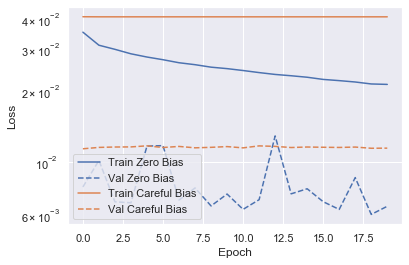

In [368]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [369]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    trainAttrX, 
    np.array(trainY1),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_split=0.2)

Train on 280092 samples, validate on 70023 samples
Epoch 1/100
280092/280092 [==============================] - 27s 95us/sample - loss: 0.0409 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 278179.0000 - fn: 1913.0000 - accuracy: 0.9932 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5090 - val_loss: 0.0115 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 69957.0000 - val_fn: 66.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/100
280092/280092 [==============================] - 23s 82us/sample - loss: 0.0409 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 278179.0000 - fn: 1913.0000 - accuracy: 0.9932 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5001 - val_loss: 0.0114 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 69957.0000 - val_fn: 66.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/100
280092/280092 [==============================] - 23s 84us/sample - loss: 

Epoch 20/100
280092/280092 [==============================] - 23s 82us/sample - loss: 0.0253 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 278179.0000 - fn: 1913.0000 - accuracy: 0.9932 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9334 - val_loss: 0.0062 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 69957.0000 - val_fn: 66.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8641
Epoch 21/100
280092/280092 [==============================] - 24s 84us/sample - loss: 0.0248 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 278179.0000 - fn: 1913.0000 - accuracy: 0.9932 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9336 - val_loss: 0.0109 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 69957.0000 - val_fn: 66.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9491
Epoch 22/100
280092/280092 [==============================] - 24s 85us/sample - loss: 0.0242 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2

In [370]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

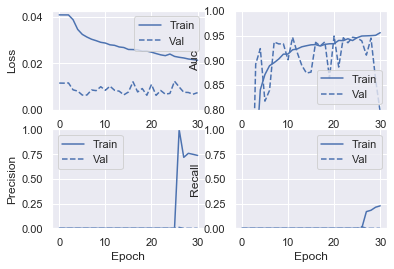

In [371]:
plot_metrics(baseline_history)

In [372]:
train24_predictions_baseline = model.predict(trainAttrX, batch_size=BATCH_SIZE)
test24_predictions_baseline = model.predict(testAttrX, batch_size=BATCH_SIZE)

In [373]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.021922834048308363
tp :  0.0
fp :  0.0
tn :  348136.0
fn :  1979.0
accuracy :  0.9943476
precision :  0.0
recall :  0.0
auc :  0.9520491

Legitimate Transactions Detected (True Negatives):  348136
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  1979
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  1979


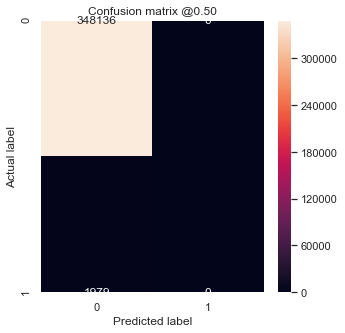

In [374]:
baseline_results = model.evaluate(trainAttrX, np.array(trainY1),
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(trainY1, train24_predictions_baseline)


In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
plot_roc("Train Baseline", trainY1, train24_predictions_baseline, color=colors[0])
plt.legend(loc='lower right')

In [280]:
np.unique(test_predictions_baseline)

array([0.0000000e+00, 2.9802322e-08, 5.9604645e-08, ..., 9.7624648e-01,
       9.7922271e-01, 9.8069167e-01], dtype=float32)

In [284]:
np.round(test_predictions_baseline)

(3539, 1)

## Baseline Model for 48hour ahead

In [289]:
neg, pos = np.bincount(mix_train['x48h_cond_loc'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 350115
    Positive: 1979 (0.57% of total)



In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          2400, activation='relu',
          input_shape=(trainAttrX.shape[-1],)),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(100, activation='relu'),
      keras.layers.Dense(2, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer='adam',
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [290]:
model = make_model()
model.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_338 (Dense)            (None, 1024)              16384     
_________________________________________________________________
dense_339 (Dense)            (None, 256)               262400    
_________________________________________________________________
dense_340 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_341 (Dense)            (None, 2)                 202       
_________________________________________________________________
dense_342 (Dense)            (None, 1)                 3         
Total params: 304,689
Trainable params: 304,689
Non-trainable params: 0
_________________________________________________________________


In [291]:
initial_bias = np.log([pos/neg])
initial_bias

array([-5.17000154])

In [292]:
pos/neg

0.005684560056989222

In [293]:
model = make_model(output_bias = initial_bias)
model.predict(trainAttrX[:10])

array([[0.00595057],
       [0.00591797],
       [0.00594261],
       [0.00583452],
       [0.0058412 ],
       [0.00593594],
       [0.0059382 ],
       [0.00586614],
       [0.00594036],
       [0.0059531 ]], dtype=float32)

In [294]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [295]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    trainAttrX, 
    np.array(trainY2),
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.2, 
    verbose=0)

In [296]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    trainAttrX, 
    np.array(trainY2),
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.2, 
    verbose=0)

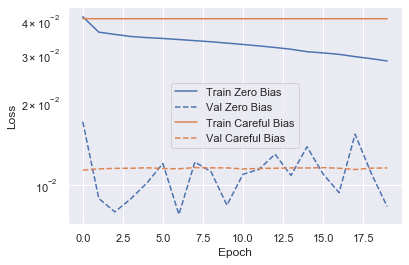

In [297]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [298]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    trainAttrX, 
    np.array(trainY2),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_split=0.2)

Train on 280092 samples, validate on 70023 samples
Epoch 1/100
280092/280092 [==============================] - 24s 87us/sample - loss: 0.0409 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 278179.0000 - fn: 1913.0000 - accuracy: 0.9932 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - val_loss: 0.0112 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 69957.0000 - val_fn: 66.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/100
280092/280092 [==============================] - 22s 79us/sample - loss: 0.0409 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 278179.0000 - fn: 1913.0000 - accuracy: 0.9932 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - val_loss: 0.0115 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 69957.0000 - val_fn: 66.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/100
280092/280092 [==============================] - 23s 81us/sample - loss: 

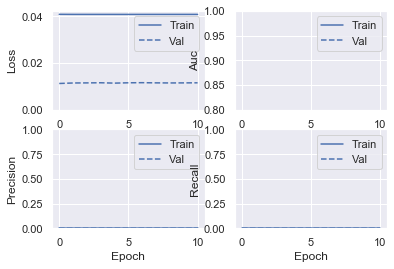

In [299]:
plot_metrics(baseline_history)

In [300]:
train48_predictions_baseline = model.predict(trainAttrX, batch_size=BATCH_SIZE)
test48_predictions_baseline = model.predict(testAttrX, batch_size=BATCH_SIZE)

loss :  0.034946494952165605
tp :  0.0
fp :  0.0
tn :  348136.0
fn :  1979.0
accuracy :  0.9943476
precision :  0.0
recall :  0.0
auc :  0.5

Legitimate Transactions Detected (True Negatives):  348136
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  1979
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  1979


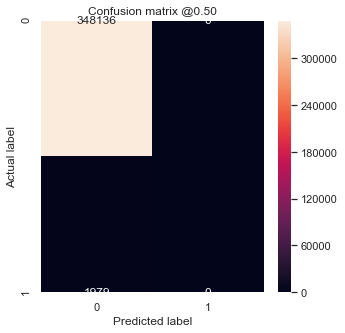

In [301]:
baseline_results = model.evaluate(trainAttrX, np.array(trainY2),
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(trainY2, train48_predictions_baseline)



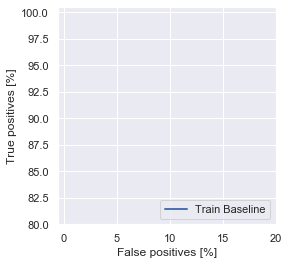

In [302]:
plot_roc("Train Baseline", trainY2, train48_predictions_baseline, color=colors[0])
plt.legend(loc='lower right')

In [303]:
np.unique(test48_predictions_baseline)

array([0.00647512, 0.00647512], dtype=float32)

In [304]:
test48_predictions_baseline

array([[0.00647512],
       [0.00647512],
       [0.00647512],
       ...,
       [0.00647512],
       [0.00647512],
       [0.00647512]], dtype=float32)